# ลง Package ที่จำเป็นก่อนใช้งานดังนี้
- pip install ipython
- pip install twitter
- pip install wordcloud
- pip install tensorflow
- pip install keras
- pip install deepcut
- pip install langdetect

### import library ที่สำคัญ

In [1]:
import deepcut
from pythainlp.corpus import stopwords
from pythainlp.tokenize import word_tokenize
from wordcloud import (WordCloud, get_single_color_func)
from matplotlib import pyplot as plt
import os ## สำหรับใช้กับ mac
import json
os.environ['KMP_DUPLICATE_LIB_OK']='True' ## สำหรับใช้กับ mac

Using TensorFlow backend.


In [2]:
#import for clean data
from langdetect import detect
import string
import re

### อ่านคำแง่บวกแง่ลบมาจากไฟล์ ที่มา https://github.com/PyThaiNLP/lexicon-thai

In [3]:
pos = []
with open("pos.txt", "r") as ins:
    for line in ins:
        pos.append(line)
pos = [''.join(c for c in text if c not in '\n') for text in pos]
neg = []
with open("neg.txt", "r") as ins:
    for line in ins:
        neg.append(line)
neg = [''.join(c for c in text if c not in '\n') for text in neg]

### คลาสสำหรับทำกรุปสีใน wordcloud

In [4]:
class SimpleGroupedColorFunc(object):

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

### ใส่คีย์สำหรับดึข้อมูลจากทวิตเตอร์

In [18]:
from twitter import *
t = Twitter(auth=OAuth('CONSUMER_KEY',
                       'CONSUMER_SECRET',
                       'ACCESS_TOKEN',
                       'ACCESS_SECRET'))

### ดึงข้อมูลจากทวิตเตอร์ตามคำค้นต่างๆ

In [6]:
results = []
results.append(t.search.tweets(q="ลำปาง -filter:retweets",count=10000,tweet_mode='extended'))
results.append(t.search.tweets(q="วัดพระธาตุลำปางหลวง -filter:retweets",count=10000,tweet_mode='extended'))
results.append(t.search.tweets(q="สะพานขาว -filter:retweets",count=10000,tweet_mode='extended'))
results.append(t.search.tweets(q="แจ้ซ้อน -filter:retweets",count=10000,tweet_mode='extended'))
results.append(t.search.tweets(q="วัดพระแก้วดอนเต้าสุชาดาราม -filter:retweets",count=10000,tweet_mode='extended'))
results.append(t.search.tweets(q="กาดกองต้า -filter:retweets",count=10000,tweet_mode='extended'))
#count สำหรับ max สุดของจำนวนที่จะค้นหา

### ฟังก์ชันสำหรับคลีนข้อความไม่ให้มีอีโม หรืออักขระไม่พึงประสงค์

In [7]:
# clean data
def cleandata(search_result):
    list_sentent = []
    for ret in search_result:
        ret['full_text'] = re.sub(r'https?:\/\/(.+?)(\/.*)', "", ret['full_text']) # link pattern
        list_word = word_tokenize(ret['full_text'])
        list_word = [''.join(c for c in word if c not in string.punctuation) for word in list_word] #ลบสัญลักษณ์
        list_word = [word for word in list_word if word] #ทำให้เหลือแต่ตัวที่ไม่สัญลักษณ์
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)
        list_word = [emoji_pattern.sub(r'', word) for word in list_word] #ลบ emoji
        list_word = [word.replace(" ", "") for word in list_word]
        list_word = [word for word in list_word if word != ''] #ลบช่องว่าง
        list_word = [''.join(c for c in text if c not in '\n') for text in list_word] #ลบขึ้นบรรทัดใหม่
        list_word = [word for word in list_word if not any(x.isdigit() for x in word)] #ลบตัวเลข
        list_sentent.append(''.join(list_word))
    return list_sentent

### ฟังก์ชันตัดคำที่ไม่มีความหมาย

In [8]:
#delete stop word
def delStopWord(search_result):
    list_sentent = []
    for ret in search_result:
        list_word = word_tokenize(ret)
        list_word = [word for word in list_word if word not in stopwords.words('thai')]
        list_sentent.append(''.join(list_word))
    return list_sentent

In [9]:
data = []
for result in results:
    data = data + cleandata(result['statuses'])

In [10]:
data_forwordcloud = delStopWord(data)

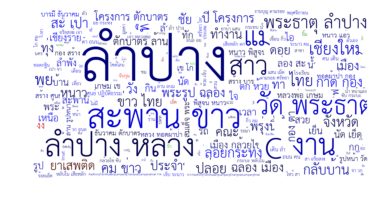

In [11]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(data_forwordcloud))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('output.jpg')

### ฟังก์ชันทำ Sentiment 

In [12]:
def countSentiment(sentence,wordList,polarity):
    count = 0
    list = []
    for word in wordList:
        if word in sentence:
            count += sentence.count(word)
            list.append(polarity + word)
    return [count,list]


def sentimentType(sentence):
    
    posCount = countSentiment(sentence,pos,'+')
    negCount = countSentiment(sentence,neg,'-')
    #neuCount = countSentiment(sentence,neu)
    r = [''.join(sentence),
         posCount[1] + negCount[1]]
    if(posCount[0] > negCount[0]):
        r[1].append('positive')
    elif posCount[0] < negCount[0]:
        r[1].append('negative')
    else:
        r[1].append('-')
    
    return r

In [13]:
def cleansentent(sentent):
    sentent = re.sub(r'https?:\/\/(.+?)(\/.*)', "", sentent) # link pattern
    list_word = word_tokenize(sentent)
    list_word = [''.join(c for c in word if c not in string.punctuation) for word in list_word] #ลบสัญลักษณ์
    list_word = [word for word in list_word if word] #ทำให้เหลือแต่ตัวที่ไม่สัญลักษณ์
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    list_word = [emoji_pattern.sub(r'', word) for word in list_word] #ลบ emoji
    list_word = [word.replace(" ", "") for word in list_word]
    list_word = [word for word in list_word if word != ''] #ลบช่องว่าง
    list_word = [''.join(c for c in text if c not in '\n') for text in list_word] #ลบขึ้นบรรทัดใหม่
    list_word = [word for word in list_word if not any(x.isdigit() for x in word)] #ลบตัวเลข
    return list_word

In [25]:
full_result_pos = []
full_result_neg = []
full_result_neu = []
for result in results:
    for ret in result['statuses']:
        data = cleansentent(ret['full_text'])
        data = delStopWord(data)
        output = sentimentType(data)
        if output[1][len(output[1])-1] == 'positive':
            full_result_pos.append(ret['full_text'])
        elif output[1][len(output[1])-1] == 'negative':
            full_result_neg.append(ret['full_text'])
        else:
            full_result_neu.append(ret['full_text'])

### ทวิตแง่บวก

In [26]:
full_result_pos

['“ปันรักละมุนใจ เติมสุขให้น้องบนดอย”\n\nมณฑลทหารบกที่ 32 พร้อมหน่วยแพทย์เคลื่อนที่ รพ.ค่ายสุรศักดิ์มนตรี ร่วมกิจกรรม ปันรักละมุนใจ เติมสุขให้น้องบนดอย ร่วมกับชมรมวิทยุหลักกิโลเมตรยักษ์ จ.ลำปาง ซึ่งแจกสิ่งของและ เครื่องกันหนาว ให้กับเด็กนักเรียนและประชาชนในพื้นที่ บ้านวังใหม่ จ.ลำปาง ',
 'เกลียดรพ.มธ.อ่ะ รักและคิดถึงโรงพยาบาลที่ลำปางมากๆ ขอบคุณตัวเองด้วยที่ไม่ป่วยแบบรุนแรงเลย',
 'ลำปางพร้อมจัด"งานบุญตามรอยศรัทธา ไหว้สาอริยสงฆ์เจ้า หลวงพ่อเกษม เขมโก  #คมข่าวทั่วไทย ',
 'ลำปางพร้อมจัด"งานบุญตามรอยศรัทธา ไหว้สาอริยสงฆ์เจ้า หลวงพ่อเกษม เขมโก  #คมข่าวทั่วไทย ',
 'ลำปางพร้อมจัด"งานบุญตามรอยศรัทธา ไหว้สาอริยสงฆ์เจ้า หลวงพ่อเกษม เขมโก  #คมข่าวทั่วไทย ',
 '@ppTdsG51d0DxMfz ชอบๆครับลำปาง',
 '@sanzokung ขอบคุณนะครับพี่ป๋วย ลำปางกลางคืนหนาวจริงๆครับช่วงนี้ 😂',
 'พรุ่งนี้ก็กลับแล้ว คิดถึงคนทางโน้น สักวันคงมีโอกาสได้เที่ยวด้วยกันนะ #เที่ยวไทยเท่ #ลำปาง @ บ้านแม่แจ๋ม ',
 'จะเอาคะแนนจากไหนให้เธอ...\nสอบไปแล้วหมดสมอง...\nคะแนนที่ออกมานั้นนึกว่าเงินทอน..\n\nอีกไม่ถึง 15 วันรอบ Port จะเริ่มแล้ว...\n#สู้ๆ

### ทวิตแง่ลบ

In [27]:
full_result_neg

['สาวสวยรับงานลำปาง ไอดีไลน์ sa78p #24ไซด์ไลน์ #Sideline #กระหรี่ #ขายตัว #รับงาน #ขายหี #ขายบริการ #นัดเย็ด #หีน่าเลีย #หีน่าเลีย #ไซด์ไลน์ #แฟนฟินฟิน #เย็ดนักศึกษา #เย็ดพริตตี้ #ไซด์ไลน์รับงาน #สาวรับงาน #รับงานลำปาง #เสียวหีน้ําแฉะ ',
 'สาวเมืองกล้วยไข่ขับกระบะเกิดหลับในเสียหลักตกห้วยเจ็บระนาว #คมข่าวทั่วไทย #ลำปาง ',
 'สาวเมืองกล้วยไข่ขับกระบะเกิดหลับในเสียหลักตกห้วยเจ็บระนาว #คมข่าวทั่วไทย #ลำปาง ',
 'สาวเมืองกล้วยไข่ขับกระบะเกิดหลับในเสียหลักตกห้วยเจ็บระนาว #คมข่าวทั่วไทย #ลำปาง ',
 '@hmdTaMLoNg3HTMH ลำปางเงี่ยนๆทักมานัดมาครับ',
 'สาวลำปาง เงี่ยน นัดเย็ดกันครับ ขอคนจริงๆ น้ำลายผ่านๆไป',
 'อยากเย็ดสาวลำปางจังเลยมีใครใจๆทักมาคุยกันได้นะ',
 'ลำปาง มิตรชัย กระทงหลงทาง @helixmarkleee',
 'แม่โทรมาบอกมีจดหมายปรับขับรถที่ลำปาง ไปตอนไหนว้าาาาา งงเวอร์',
 '@pumpkin_b ถูกจังวะ หาก่องว่าลำปางมีมะ หลอกแม่ต่อ',
 'หน้าคลินิคเขาลองไฟละเว่ยแกร  ล่องสะเปา เมืองลำปางงงงง โคมไฟสวยมาก มาถ่ายรูปได้',
 '19 พ.ย.61 บช.ปส.แถลงผลการจับกุมขบวนการค้ายาเสพติด 2 คดีคือ \n-คดีแรก จับกุมผู้ต้องหา 3 ราย พร้อมยาบ้

### ทวิตที่ไม่สามารถระบุได้

In [28]:
full_result_neu

['ลำปางไม่หนาวลำพัง',
 'ละลานตาโคมล้านนากว่า 1,000 ดวง ประดับทั่วเมืองลำปางรับเทศกาล #ล่องสะเปาจาวละกอน หรือลอยกระทง  21-23 พ.ย. ริมแม่น้ำวัง @TNAMCOT #ลอยกระทง ',
 'ลำปางทักตอนนี้ดูดให้ผมหน่อย',
 'ปิดทองพระแก้วมรกต ณ วัดพระธาตุลำปางหลวง ',
 "I'm at ตึก1 ราชภัฏลำปาง ",
 'พระธาตุลำปางหลวง จ.ลำปาง ',
 'LEO FARM @CentralPlaza Lampang วันที่ 20 - 25 พฤศจิกายน 2561 ณ ศูนย์การค้าเซ็นทรัลพลาซา ลำปาง\n-- ',
 'มธ ลำปาง แม่งอยู่โคตรลึก โคตรไกล ไม่มีอะไรให้กินเลยอ่ะ',
 'ลูกเสือทั้งหลาย ,,, พร้อม ?!?! @ โรงเรียนอัสสัมชัญ ลำปาง ',
 '@gardthirdx พี่ลำปาง',
 'โครงการส่งน้ำฯ ลำปาง ร่วมสืบสานประเพณีไทยล่องสะเปาจาวละกอน หรือลอยกระทง ปล่อยน้ำเขื่อนกิ่วลมสู่แม่น้ำวังวันละเกือบ 2 ล้าน ลบ.ม. ยืนยันไม่กระทบน้ำใช้หน้าแล้ง   #สำนักข่าวไทย  @politics_mcot @DaweeTV9 @tiamoNOK @junejune55',
 'โครงการส่งน้ำฯ ลำปาง ร่วมสืบสานประเพณีไทยล่องสะเปาจาวละกอน หรือ ลอยกระทง ปล่อยน้ำเขื่อนกิ่วลมสู่แม่น้ำวัง วันละเกือบ 2 ล้าน ลบ.ม. ยืนยันไม่กระทบน้ำใช้หน้าแล้ง คลิก ►  ',
 'เขื่อนกิ่วลม-ลำปาง ปล่อยน้ำวันละเกือบ 2 ล้าน ลบ.ม. ส